# Quantitative Analysis of Price & Daily Returns
* Can returns be described with a normal distribution?
* Is daily change non-zero?
* Can price movement be described as a random walk?

### 1. Set up environment 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 8, 6
import seaborn as sb
sb.set()
import pandas_datareader as pdr

### 2.  Download stock price data, store in dataframe

In [3]:
amzn = pdr.get_data_yahoo('AMZN')

### 3. Take a look at the data

In [4]:
amzn.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-06-03,727.000000,718.429993,726.739990,725.539978,3367300,725.539978
2016-06-06,731.500000,724.419983,726.500000,726.729980,2704800,726.729980
2016-06-07,730.000000,720.549988,729.890015,723.739990,2732500,723.739990
2016-06-08,729.419983,721.599976,726.400024,726.640015,2223400,726.640015
2016-06-09,728.909973,722.299988,723.099976,727.650024,2170300,727.650024


### 4. Store instantaneous rate of return in separate series

In [6]:
amzn_return = round(np.log(amzn.Close).diff() * 100, 2)
amzn_return.dropna(inplace = True)
amzn_return.head()

Date
2016-06-06    0.16
2016-06-07   -0.41
2016-06-08    0.40
2016-06-09    0.14
2016-06-10   -1.35
Name: Close, dtype: float64

### 5. Plot the series 

<AxesSubplot:xlabel='Date'>

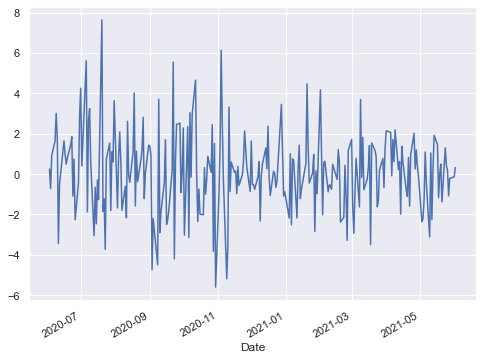

In [8]:
amzn_return[-252:].plot()

### 6. Pandas describe function gives descriptive statistics, default assumes you are dealing with a sample Pandas also deals with missing values by omitting them 

In [9]:
amzn_return.describe()

count    1257.000000
mean        0.118767
std         1.828797
min        -8.250000
25%        -0.710000
50%         0.150000
75%         1.040000
max        12.410000
Name: Close, dtype: float64

### 7. An alternative more slightly  different table of descriptives from scipy stats

In [10]:
from scipy import stats

In [15]:
n, minmax, mean, var, skew, kurt = stats.describe(amzn_return)
mini, maxi = minmax
std = var ** .5

### 9. for comparision generate random numbers that follow normal distribution


In [16]:
from scipy.stats import norm

In [17]:
x = norm.rvs(mean, std, n)

In [20]:
stats.describe(x)

DescribeResult(nobs=1257, minmax=(-5.667586139363219, 6.6025928351128975), mean=0.10969789971833238, variance=3.3950973838450786, skewness=0.04822423578358121, kurtosis=-0.11797296454092399)

(array([  3.,  16.,  19.,  66., 131., 165., 224., 219., 156., 131.,  78.,
         32.,  12.,   4.,   1.]),
 array([-5.66758614, -4.84957421, -4.03156228, -3.21355034, -2.39553841,
        -1.57752648, -0.75951455,  0.05849738,  0.87650931,  1.69452125,
         2.51253318,  3.33054511,  4.14855704,  4.96656897,  5.7845809 ,
         6.60259284]),
 <BarContainer object of 15 artists>)

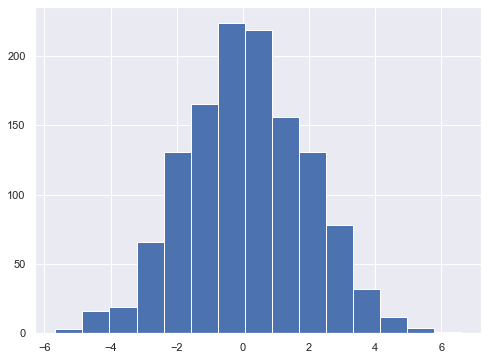

In [21]:
plt.hist(x, bins=15)

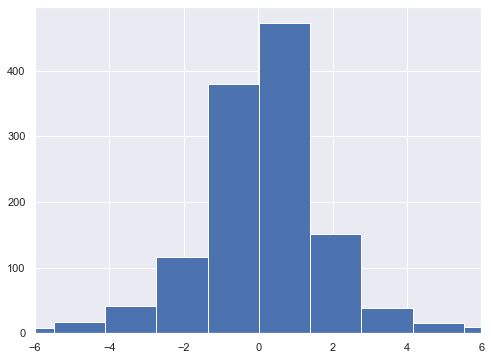

In [23]:
plt.hist(amzn_return, bins = 15)
plt.xlim(-6,6);

## Is price change normally distributed?

### 10. Use scipy stats to test the kurtosis, the null hypothesis is that the sample is drawn from a population where the underlying kurtosis is that of a normally distributed variable

In [25]:
x_test = stats.kurtosistest(x)
amzn_test = stats.kurtosistest(amzn_return)
print(f'{"     Test statistic":20}{"p-value":>15}')
print(f'{" "*5}{"-"* 30}')
print(f"x:{x_test[0]:>17.2f}{x_test[1]:16.4f}")
print(f"AMZN: {amzn_test[0]:13.2f}{amzn_test[1]:16.4f}")

     Test statistic         p-value
     ------------------------------
x:            -0.81          0.4168
AMZN:         11.47          0.0000


### 11. plot histogram of price changes with normal curve overlay


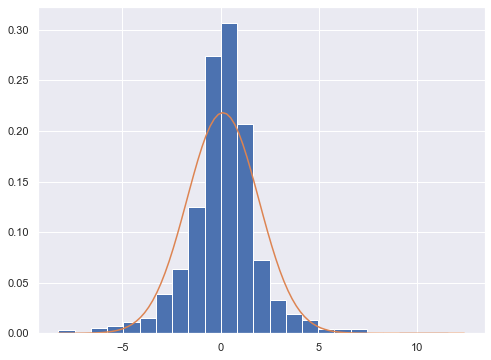

In [28]:
plt.hist(amzn_return, bins = 25, edgecolor='w', density= True)
data = np.linspace(mini, maxi, 100)
plt.plot(data, norm.pdf(data, mean, std));

### 12. Compare normally distributed sample with same attributes as amzn price change

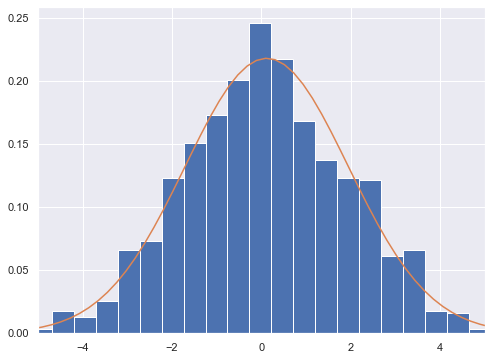

In [30]:
plt.hist(x, bins =25, density = True)
b = np.linspace(mini, maxi, 100)
plt.plot(b,stats.norm.pdf(b, mean, std))
plt.xlim(-5,5);

## Is daily price change significantly different from zero?

### 13. Conduct simple hypothesis test

In [33]:
stats.ttest_1samp(amzn_return.sample(252), 0, alternative='two-sided')

Ttest_1sampResult(statistic=1.4743142468193604, pvalue=0.14165011186612425)

## Can price movement be described as a random walk?

### 14. Create price lags

In [44]:
amzn_close = pd.DataFrame(amzn.Close, columns= ['Close'])
amzn_close['lag_1'] = amzn_close.Close.shift(1)
amzn_close['lag_2'] = amzn_close.Close.shift(2)
amzn_close.dropna(inplace = True)
amzn_close.head()

,Close,lag_1,lag_2
Date,,,
2016-06-07,723.739990,726.729980,725.539978
2016-06-08,726.640015,723.739990,726.729980
2016-06-09,727.650024,726.640015,723.739990
2016-06-10,717.909973,727.650024,726.640015
2016-06-13,715.239990,717.909973,727.650024


### 15. Fit linear model

In [48]:
lr = np.linalg.lstsq(amzn_close[['lag_1', 'lag_2']], amzn_close.Close, rcond=None)[0]

In [49]:
amzn_close['predict'] = np.dot(amzn_close[['lag_1', 'lag_2']], lr)

In [50]:
amzn_close.head()

,Close,lag_1,lag_2,predict
Date,,,,
2016-06-07,723.739990,726.729980,725.539978,727.325283
2016-06-08,726.640015,723.739990,726.729980,724.580125
2016-06-09,727.650024,726.640015,723.739990,727.133955
2016-06-10,717.909973,727.650024,726.640015,728.256831
2016-06-13,715.239990,717.909973,727.650024,719.144556


<AxesSubplot:xlabel='Date'>

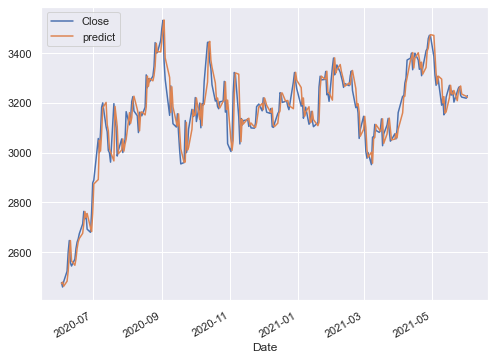

In [52]:
amzn_close.iloc[-252:][['Close', 'predict']].plot()